In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

In [19]:
class Score_Sampler():
    def __init__(self, bmin = 1.0, bmax = 1.0):
        self.bmin = bmin
        self.bmax = bmax

    def beta_funtion(self,t):
        bmin = self.bmin
        bmax = self.bmax
        return bmin + (bmax - bmin)*t

    def beta_funtion_integral(self, t):
        bmin = 1.0
        bmax = 1.0
        return bmin*t + (bmax - bmin)*(t**2)/2

    def compute_a(self, t):
        beta_integral = self.beta_funtion_integral(t)
        return np.exp(- 0.5 * beta_integral) + 1e-5

    def compute_sigma(self, t):
        beta_integral = self.beta_funtion_integral(t)
        return np.sqrt(1 - np.exp( - beta_integral)) + 1e-5

    def MC_estimator_score(self, t, X, pi, sample_size):
        pass

    def sample(self, pi, dim, batch_size, sample_size, T = 3, N = 1000):
        X = np.random.normal(size = (batch_size, dim))
        dt = T/N
        for i in range(0, N):
            t = dt * i
            score = self.MC_estimator_score(T - t, X, pi, sample_size)
            beta = self.beta_funtion(T - t)
            drift = beta * X / 2 + beta * score
            vol = np.sqrt(beta)
            dW =  np.sqrt(dt)*np.random.normal(size = (batch_size, dim)) 
            X = X + drift*dt + vol*dW
        return X 

In [27]:
class Log_Expansion_Score(Score_Sampler):
    def __init__(self, bmin=1, bmax=1):
        super().__init__(bmin = bmin, bmax = bmax)
    
    def MC_estimator_grad_pi_t(self, pi, X, a, sigma, sample_size):
        '''
        Estimate for E[Z \pi(X0)/(sigma)] where X0 = (sigma*Z + X)/a and Z starndar normal 

        Parameter:
            pi (funtion): (M, L, N) -> (M, L, 1)
            X  (array):   (L, N)
            a  (Float)
            sigma (Float)
            Sample_size (int)

        return:
            array:  (L, N)
        '''
        batch_size = X.shape[0]
        dim_X = X.shape[1]
        Z = np.random.randn(sample_size, batch_size, dim_X)
        X0 = (sigma * Z + X)/a
        # Aplicar pi em X0
        pi_X0 = pi(X0)
        pi_X0 = pi_X0
        expression = (Z * pi_X0) / sigma
        MC = np.mean(expression, axis = 0)
        return MC

    def unbiease_estimator_pi_t(self, pi, X, a, sigma, sample_size):
        '''
        Estimate for E[\pi(X0)] where X0 = (sigma*Z + X)/a and Z starndar normal 
        Parameter:
            pi (funtion): (M, L, N) -> (M, L, 1)
            X  (array):   (L, N)
            a  (Float)
            sigma (Float)
            Sample_size (int)

        return:
            np.array (L,)
        '''
        batch_size = X.shape[0]
        dim_X = X.shape[1]
        Z = np.random.randn(sample_size, batch_size, dim_X)
        X0 = (sigma * Z + X)/a
        # Aplicar pi em X0
        pi_X0 = pi(X0)
        MC = np.mean(pi_X0, axis = 0)
        return MC

    def MC_estimator_score(self, t, X, pi, sample_size):
        a = self.compute_a(t)
        sigma = self.compute_sigma(t)
        grad_pi_log = np.log(self.MC_estimator_grad_pi_t(pi, X, a, sigma, sample_size))
        p = 1/2
        # Note que estou gerando só um N, precisamos de vários
        N = np.random.geometric(p) - 1
        random_produc_log = 0
        for _ in range(N):
            random_produc_log += np.log(self.unbiease_estimator_pi_t(pi, X, a, sigma, sample_size))
        pi_inverse_log = random_produc_log - N*np.log(p) - np.log(1-p) 
        log_MC = grad_pi_log  + pi_inverse_log
        return np.exp(log_MC)

In [28]:
def pi_normal(X):
    mean = 0
    var = 1
    density = np.exp(- (X - mean)**2/(2*var))
    return density

C:\Users\henri\AppData\Local\Temp\ipykernel_16028\2472869561.py:55: RuntimeWarning: invalid value encountered in log
  grad_pi_log = np.log(self.MC_estimator_grad_pi_t(pi, X, a, sigma, sample_size))


<Axes: ylabel='Density'>

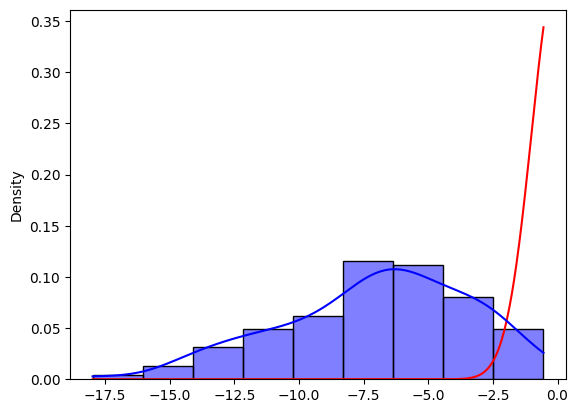

In [29]:
sampler = Log_Expansion_Score()
data = sampler.sample(pi_normal, 1, 500, 512)[:,0]
x = np.linspace(min(data), max(data), 1000)
y = norm.pdf(x, 0, 1)
plt.plot(x, y, color="red", label="Densidade Normal")
sns.histplot(data, stat = "density", kde = True, color="blue")